In [2]:
from banerjee2020_sim.halos import *
from scipy.optimize import curve_fit
from pandas import qcut
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/tdshield/banerjee2020_sim/loading.py:19: RuntimeWarning: divide by zero encountered in log10
  LOG_MORB = np.log10(HALO_CATALOG['Morb'][()])


FIGURE 1 (Left): Orbiting density profiles of 300 random halos, with 100 being pulled from a low mass bin (blue), 100 from a medium mass bin (orange), and 100 pulled from a high mass bin (green). For each bin, we take the median $\log(M_{\rm orb})$ and use it to plot Eq. 1 (black). The region with radius less than $\sim 90$ kpc $h^{-1}$ are shaded in gray, because densities in this region are not fit for due to the resolution of the simulation. (Right): $\tilde{\rho}_{\rm orb}$ for those same 300 halos overplotted, along with the model (red), which is of form $\exp(-x^2/2)$. We multiply the densities by $r^3$ and $x$, respectively, to scale the height of the profiles.

In [3]:
# Choose mass bins
Morb = HALO_CATALOG['Morb'][HALO_MASS_MASK][:192042]
mbin_indices = bin_massive_halos()[:192042]

low_ind = 1
med_ind = 4
high_ind = 7

low_mbin = (mbin_indices == low_ind)
med_mbin = (mbin_indices == med_ind)
high_mbin = (mbin_indices == high_ind)

In [4]:
# Choose 100 random haloes from each mass bin
hids = MASSIVE_HIDS[:192042]
low_mbin_hids = np.random.choice(hids[low_mbin], 100, replace=False)
med_mbin_hids = np.random.choice(hids[med_mbin], 100, replace=False)
high_mbin_hids = np.random.choice(hids[high_mbin], 100, replace=False)

In [5]:
# Get masses, densities, tilde models, and best-fit model parameters for these random halos
low_Morb = Morb[low_mbin]
med_Morb = Morb[med_mbin]
high_Morb = Morb[high_mbin]

low_mbin_dens = HALO_DENSITIES['Orb'][np.isin(hids, low_mbin_hids)]
med_mbin_dens = HALO_DENSITIES['Orb'][np.isin(hids, med_mbin_hids)]
high_mbin_dens = HALO_DENSITIES['Orb'][np.isin(hids, high_mbin_hids)]

low_mbin_rh = SIMULT_PARAMS['rh'][np.isin(hids, low_mbin_hids)]
low_mbin_alph = SIMULT_PARAMS['alpha_inf'][np.isin(hids, low_mbin_hids)]

med_mbin_rh = SIMULT_PARAMS['rh'][np.isin(hids, med_mbin_hids)]
med_mbin_alph = SIMULT_PARAMS['alpha_inf'][np.isin(hids, med_mbin_hids)]

high_mbin_rh = SIMULT_PARAMS['rh'][np.isin(hids, high_mbin_hids)]
high_mbin_alph = SIMULT_PARAMS['alpha_inf'][np.isin(hids, high_mbin_hids)]

Text(0.5, 0, '$x$')

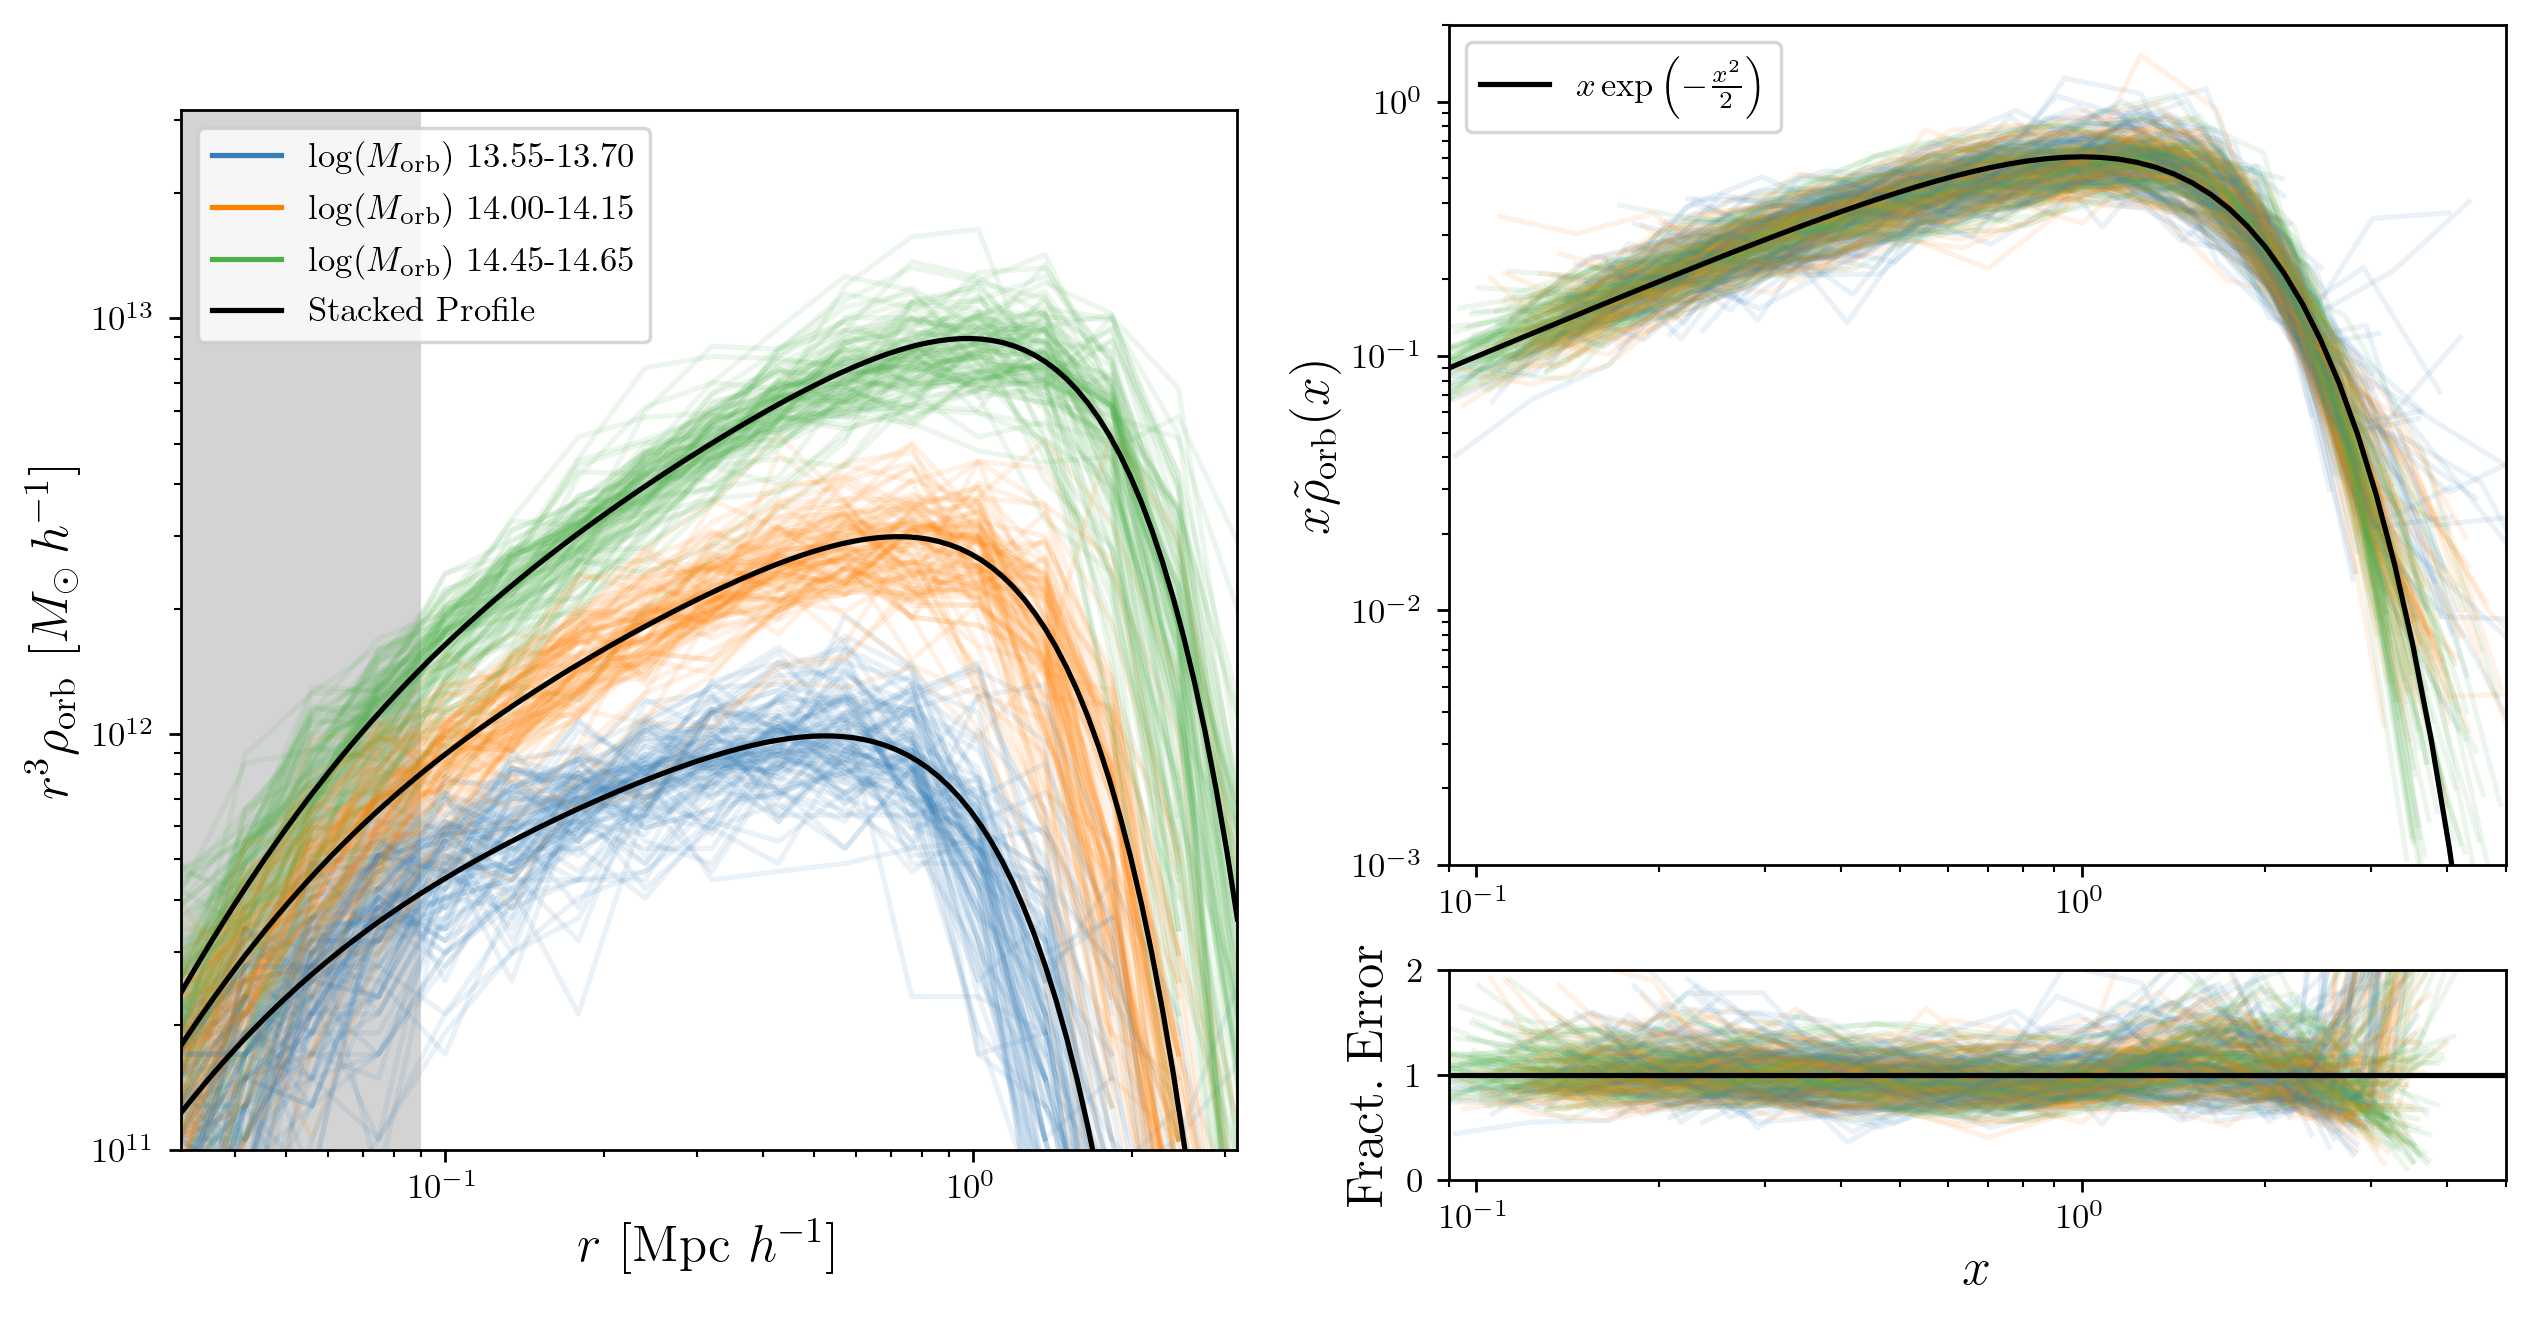

In [6]:
# FIGURE 1
latex()
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, height_ratios=(4, 1))

# Three axes
ax1 = fig.add_subplot(gs[:, 0]) # Left panel
ax2 = fig.add_subplot(gs[0, 1]) # Top right panel
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2) # Bottom right panel

# Make left panel more square and evenly positioned
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + 0.02, box.width, box.height * 0.9])



# Left panel (ax1, halo densities with stacked profile)
for i in range(100):
    low_dens = low_mbin_dens[i, :]
    med_dens = med_mbin_dens[i, :]
    high_dens = high_mbin_dens[i, :]

    if i == 0:
        low_label = '$\\log(M_{\\rm orb})$ ' + MASS_BIN_STRS[low_ind]
        med_label = '$\\log(M_{\\rm orb})$ ' + MASS_BIN_STRS[med_ind]
        high_label = '$\\log(M_{\\rm orb})$ ' + MASS_BIN_STRS[high_ind]
    else:
        low_label = None
        med_label = None 
        high_label = None

    ax1.loglog(RADIUS[low_dens > 0], (RADIUS[low_dens > 0] ** 3) * low_dens[low_dens > 0], color=COLORS[0], alpha=0.1, label=low_label)
    ax1.loglog(RADIUS[med_dens > 0], (RADIUS[med_dens > 0] ** 3) * med_dens[med_dens > 0], color=COLORS[1], alpha=0.1, label=med_label)
    ax1.loglog(RADIUS[high_dens > 0], (RADIUS[high_dens > 0] ** 3) * high_dens[high_dens > 0], color=COLORS[2], alpha=0.1, label=high_label)

# Stacked profile fit for each mass bin
r = np.logspace(-1.5, 0.5, num=100)
ax1.loglog(r, (r ** 3) * orb_model(r, 10 ** MASS[low_ind-1]), color='black', label='Stacked Profile')
ax1.loglog(r, (r ** 3) * orb_model(r, 10 ** MASS[med_ind-1]), color='black')
ax1.loglog(r, (r ** 3) * orb_model(r, 10 ** MASS[high_ind-1]), color='black')

ax1.axvspan(xmin=0, xmax=6 * R_SOFT, facecolor='lightgray') # Color region masked from fitting

ax1.set_xlabel('$r$ [Mpc $h^{-1}$]', fontsize=15)
ax1.set_ylabel('$r^3 \\rho_{\\rm orb}$ [$M_{\\odot} \\: h^{-1}$]', fontsize=15)
ax1.set_ylim(10**11, 10**13.5)
ax1.set_xlim(10**(-1.5), 10**(0.5))
leg = ax1.legend(loc='upper left')
for lh in leg.legend_handles: 
    lh.set_alpha(1)



# Top right panel (ax2, fitted model)
for i in range(100):
    low_rho_tilde, low_x = orb_model_tilde(low_mbin_dens[i, :], low_Morb[i], low_mbin_rh[i], low_mbin_alph[i])
    med_rho_tilde, med_x = orb_model_tilde(med_mbin_dens[i, :], med_Morb[i], med_mbin_rh[i], med_mbin_alph[i])
    high_rho_tilde, high_x = orb_model_tilde(high_mbin_dens[i, :], high_Morb[i], high_mbin_rh[i], high_mbin_alph[i])

    low_mask = (low_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))
    med_mask = (med_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))
    high_mask = (high_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))

    ax2.loglog(low_x[low_mask], low_x[low_mask] * low_rho_tilde[low_mask], color=COLORS[0], alpha=0.1)
    ax2.loglog(med_x[med_mask], med_x[med_mask] * med_rho_tilde[med_mask], color=COLORS[1], alpha=0.1)
    ax2.loglog(high_x[high_mask], high_x[high_mask] * high_rho_tilde[high_mask], color=COLORS[2], alpha=0.1)

x = np.logspace(-2, 1, num=100)
ax2.loglog(x, x * np.exp(-(x ** 2) / 2), color='black', label='$x \\exp \\left(-\\frac{x^2}{2} \\right)$')

ax2.set_ylabel('$x \\tilde{\\rho}_{\\rm orb}(x)$', fontsize=15)
ax2.set_ylim(1e-3, 2)
ax2.legend()



# Bottom right panel (fractional error)
for i in range(100):
    low_rho_tilde, low_x = orb_model_tilde(low_mbin_dens[i, :], low_Morb[i], low_mbin_rh[i], low_mbin_alph[i])
    med_rho_tilde, med_x = orb_model_tilde(med_mbin_dens[i, :], med_Morb[i], med_mbin_rh[i], med_mbin_alph[i])
    high_rho_tilde, high_x = orb_model_tilde(high_mbin_dens[i, :], high_Morb[i], high_mbin_rh[i], high_mbin_alph[i])

    low_mask = (low_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))
    med_mask = (med_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))
    high_mask = (high_rho_tilde > 0) & (RADIUS > (6 * R_SOFT))

    # Exponential models
    low_mod = np.exp(-(low_x ** 2) / 2)
    med_mod = np.exp(-(med_x ** 2) / 2)
    high_mod = np.exp(-(high_x ** 2) / 2)

    ax3.plot(low_x[low_mask], low_rho_tilde[low_mask] / low_mod[low_mask], color=COLORS[0], alpha=0.1)
    ax3.plot(med_x[med_mask], med_rho_tilde[med_mask] / med_mod[med_mask], color=COLORS[1], alpha=0.1)
    ax3.plot(high_x[high_mask], high_rho_tilde[high_mask] / high_mod[high_mask], color=COLORS[2], alpha=0.1)

ax3.plot(x, np.ones(shape=x.shape), color='black')

ax3.set_ylim(0, 2)
ax3.set_xlim(0.09, 5)

ax3.set_ylabel('$\\rm Fract. \\; Error$', fontsize=15)
ax3.set_xlabel('$x$', fontsize=15)


FIGURE 2: For each halo in our catalog, we take the difference between its best fit and mass-estimated asymptotic profile slope (Eq. 7) and plot it against the natural log of the ratio between its best fit and mass-estimated halo radius (Eq. 8) as a 2D histogram, with the color corresponding to the density of haloes. A linear model is fit to this data and shown as a red line.

In [7]:
# Calculate R and delta alpha for every (massive) halo
R = SIMULT_PARAMS['rh'][:] / SIMULT_PARAMS['rh_st'][:]
lnR = np.log(R)
delta_alph = SIMULT_PARAMS['alpha_inf'][:] - SIMULT_PARAMS['alpha_inf_st'][:]

In [8]:
# Fit a linear model to lnR vs delta alpha, maximizing number of haloes found within y=+- 0.03 of the line
def line(x, m, b):
    return (m * x) + b

def num_cost(params, x, y):
    m = params[0]
    a = params[1]
    n = 0
    for i in range(len(y)):
        if (y[i] > (line(x[i], m, a) - 0.03)) & (y[i] < (line(x[i], m, a) + 0.03)):
            n +=1

    return -n

result = minimize(num_cost, [1, 0], bounds=[(0.5, 1.5), (-0.5, 0.5)], method='simplex', args=(lnR, delta_alph))
s_alpha, alpha0 = result.x

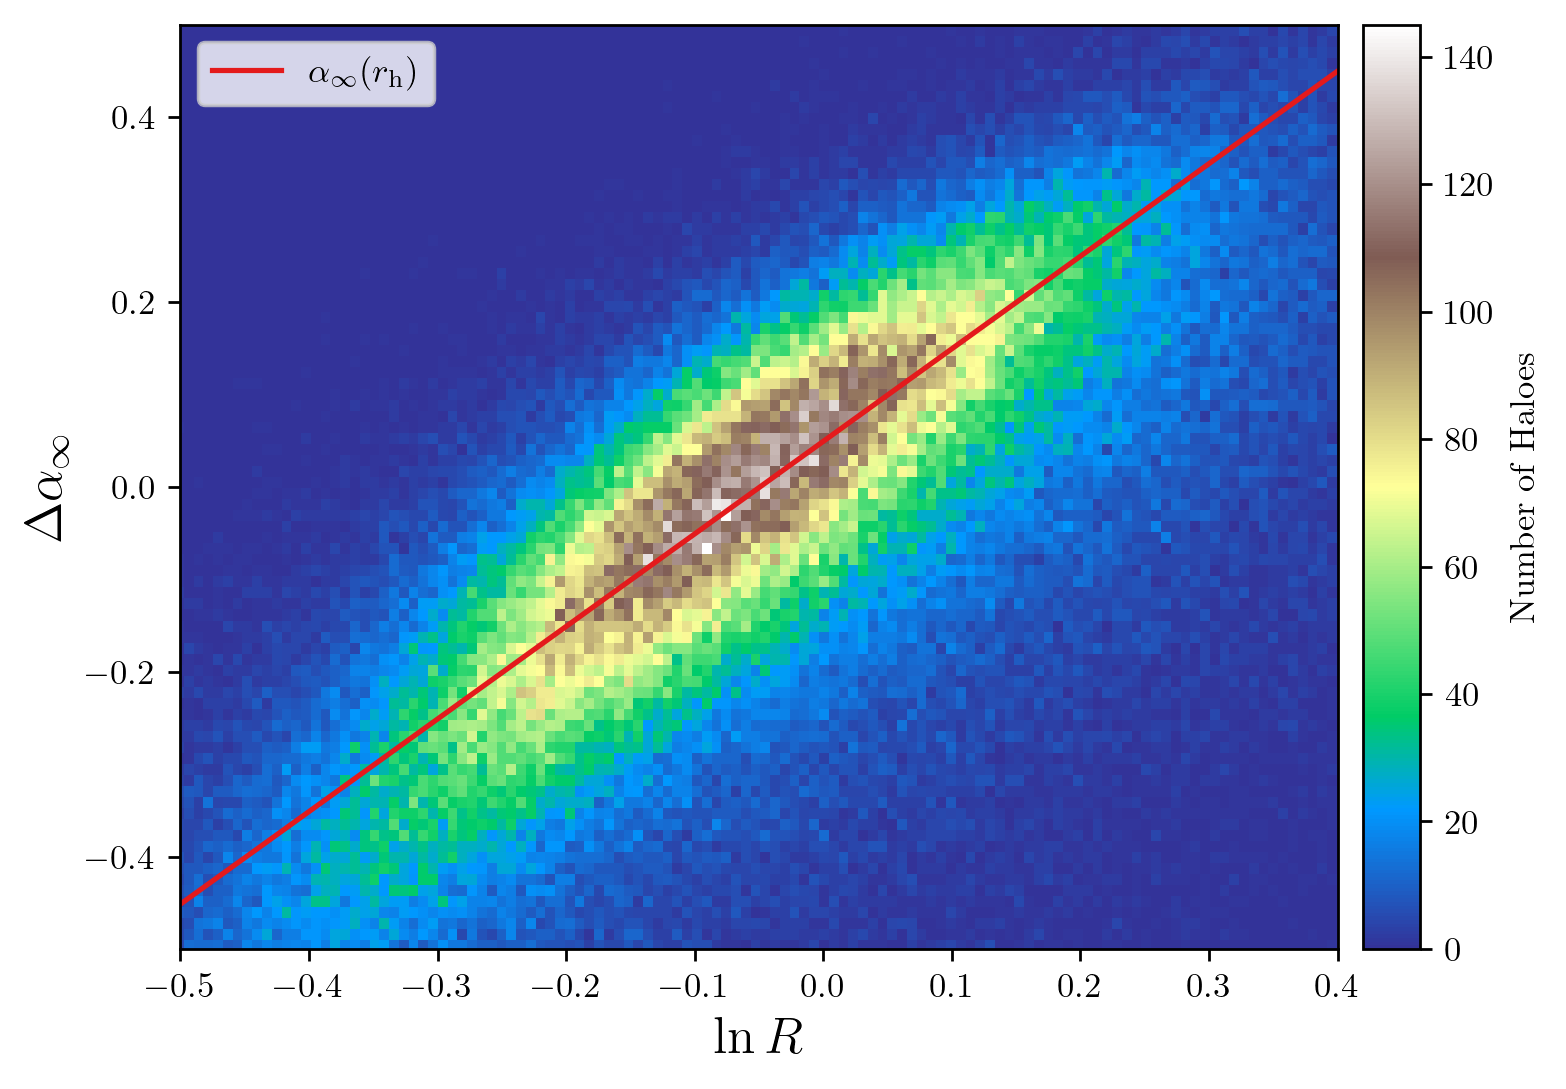

In [9]:
# FIGURE 2
plt.hist2d(lnR, delta_alph, bins=300, cmap='terrain')
x = np.linspace(-0.5, 0.4)
plt.plot(x, line(x, s_alpha, alpha0), color=COLORS[7], label='$\\alpha_{\\infty}(r_{\\rm h})$')

plt.legend()
plt.xlim(-0.5, 0.4)
plt.ylim(-0.5, 0.5)
plt.xlabel('$\\ln R$', fontsize=15)
plt.ylabel('$\\Delta \\alpha_{\\infty}$', fontsize=15)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.1)

plt.colorbar(label='$\\rm Number \\; of \\; Haloes$', cax=cax)

In [10]:
s_alpha, alpha0 # Put in constants.py

(1.0016474457286733, 0.04933732028434024)

FIGURE 3. After binning all of the haloes by $M_{\rm orb}$, then binning again by $\ln R$, we take CDFs of the particle accretion times of all the particles in those bins. A horizontal line is drawn when the CDF reaches 0.6, as at this point there is visually a clear distinction between most of the $\ln R$ bins that is approximately constant with mass.

In [11]:
# Bin lnR into bins of equal number of haloes
num_bins = 5
# __, lnR_bins = qcut(lnR, num_bins, retbins=True)
m = np.mean(lnR)
s = np.std(lnR)
lnR_bins = np.array([np.min(lnR), m - (2 * s), m - s, m, m + s, m + (2 * s), np.max(lnR)])
lnR_bins

array([-1.18129078, -0.53366139, -0.29854228, -0.06342316,  0.17169595,
        0.40681506,  1.09861229])

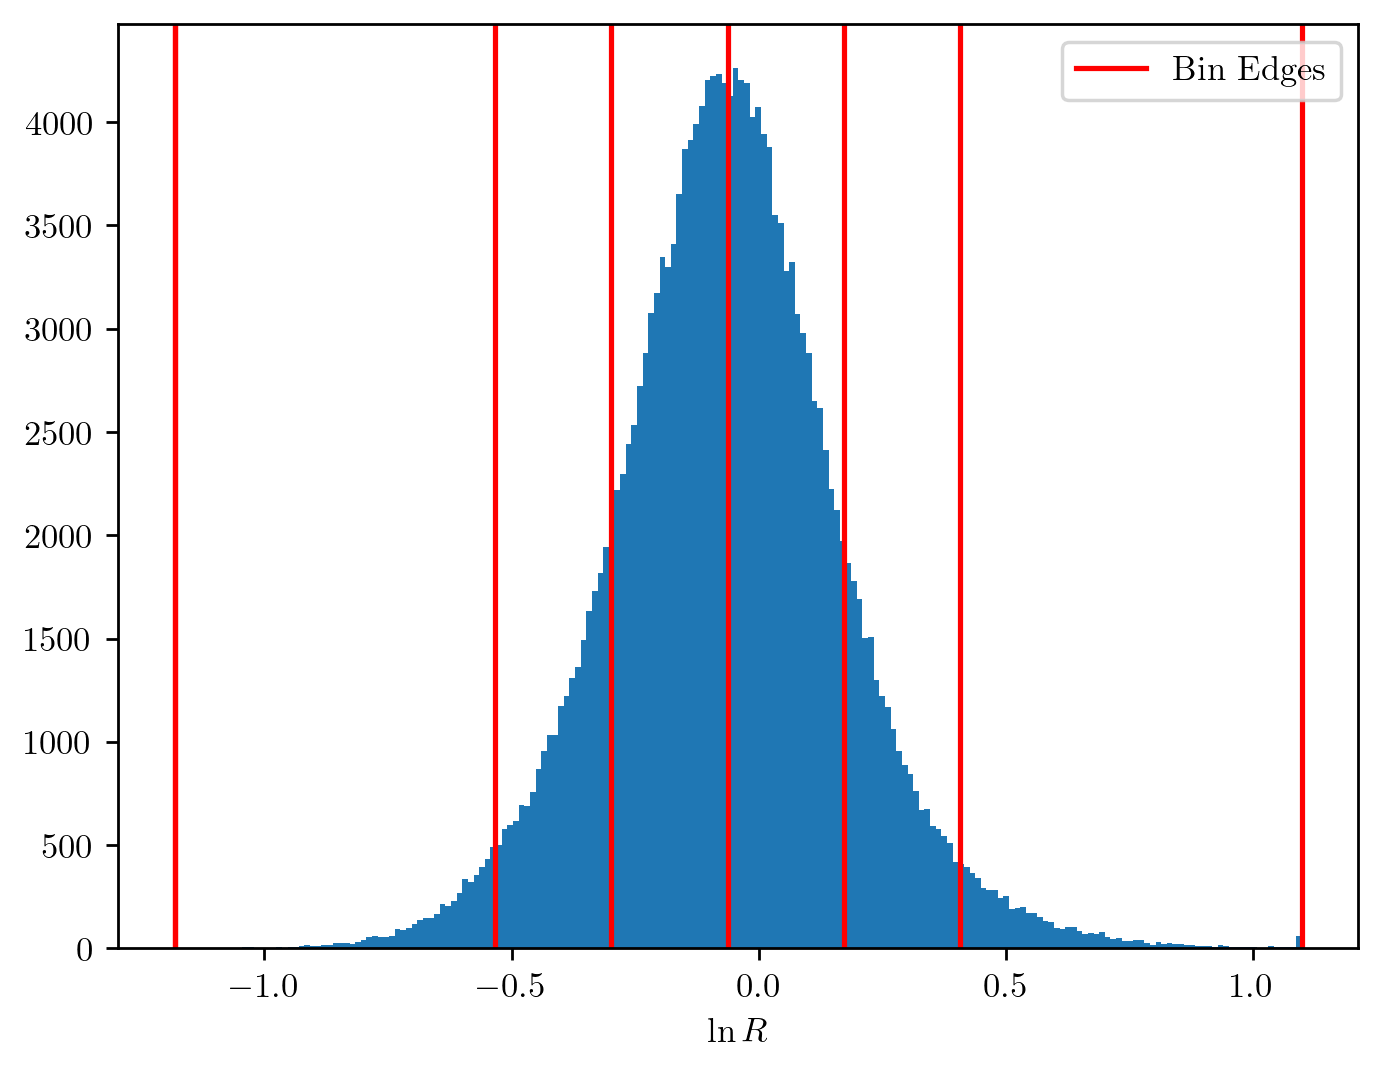

In [12]:
latex()

plt.hist(lnR, bins=200)
plt.axvline(lnR_bins[0], c='r', label='Bin Edges')
for i in range(len(lnR_bins)):
    plt.axvline(lnR_bins[i], c='r')

plt.xlabel('$\\ln R$')
plt.legend()

In [13]:
# key_list = ['-0.07 < lnR < 0.02', '-0.15 < lnR < -0.07', '-0.28 < lnR < -0.15', '-1.18 < lnR < -0.28', '0.02 < lnR < 0.14', '0.14 < lnR < 1.10']
# key_list = ['-1.18 < lnR < -0.28', '-0.28 < lnR < -0.15', '-0.15 < lnR < -0.07', '-0.07 < lnR < 0.02', '0.02 < lnR < 0.14', '0.14 < lnR < 1.10']
key_list = []
for i in range(len(LNR_BIN_EDGES) - 1):
    key_list.append(f'{LNR_BIN_EDGES[i]:.2f} < lnR < {LNR_BIN_EDGES[i+1]:.2f}')

In [14]:
P_a_acc = h5.File('shields_data_24/P_a_acc.hdf5', 'r')
P_a_acc[MASS_BIN_STRS[0] + '/' + key_list[0]]

<HDF5 dataset "-1.18 < lnR < -0.53": shape (200,), type "<f8">

In [15]:
__, a_acc_bins = np.histogram(PARTICLE_A_ACC['a_inf'][()], bins=200)

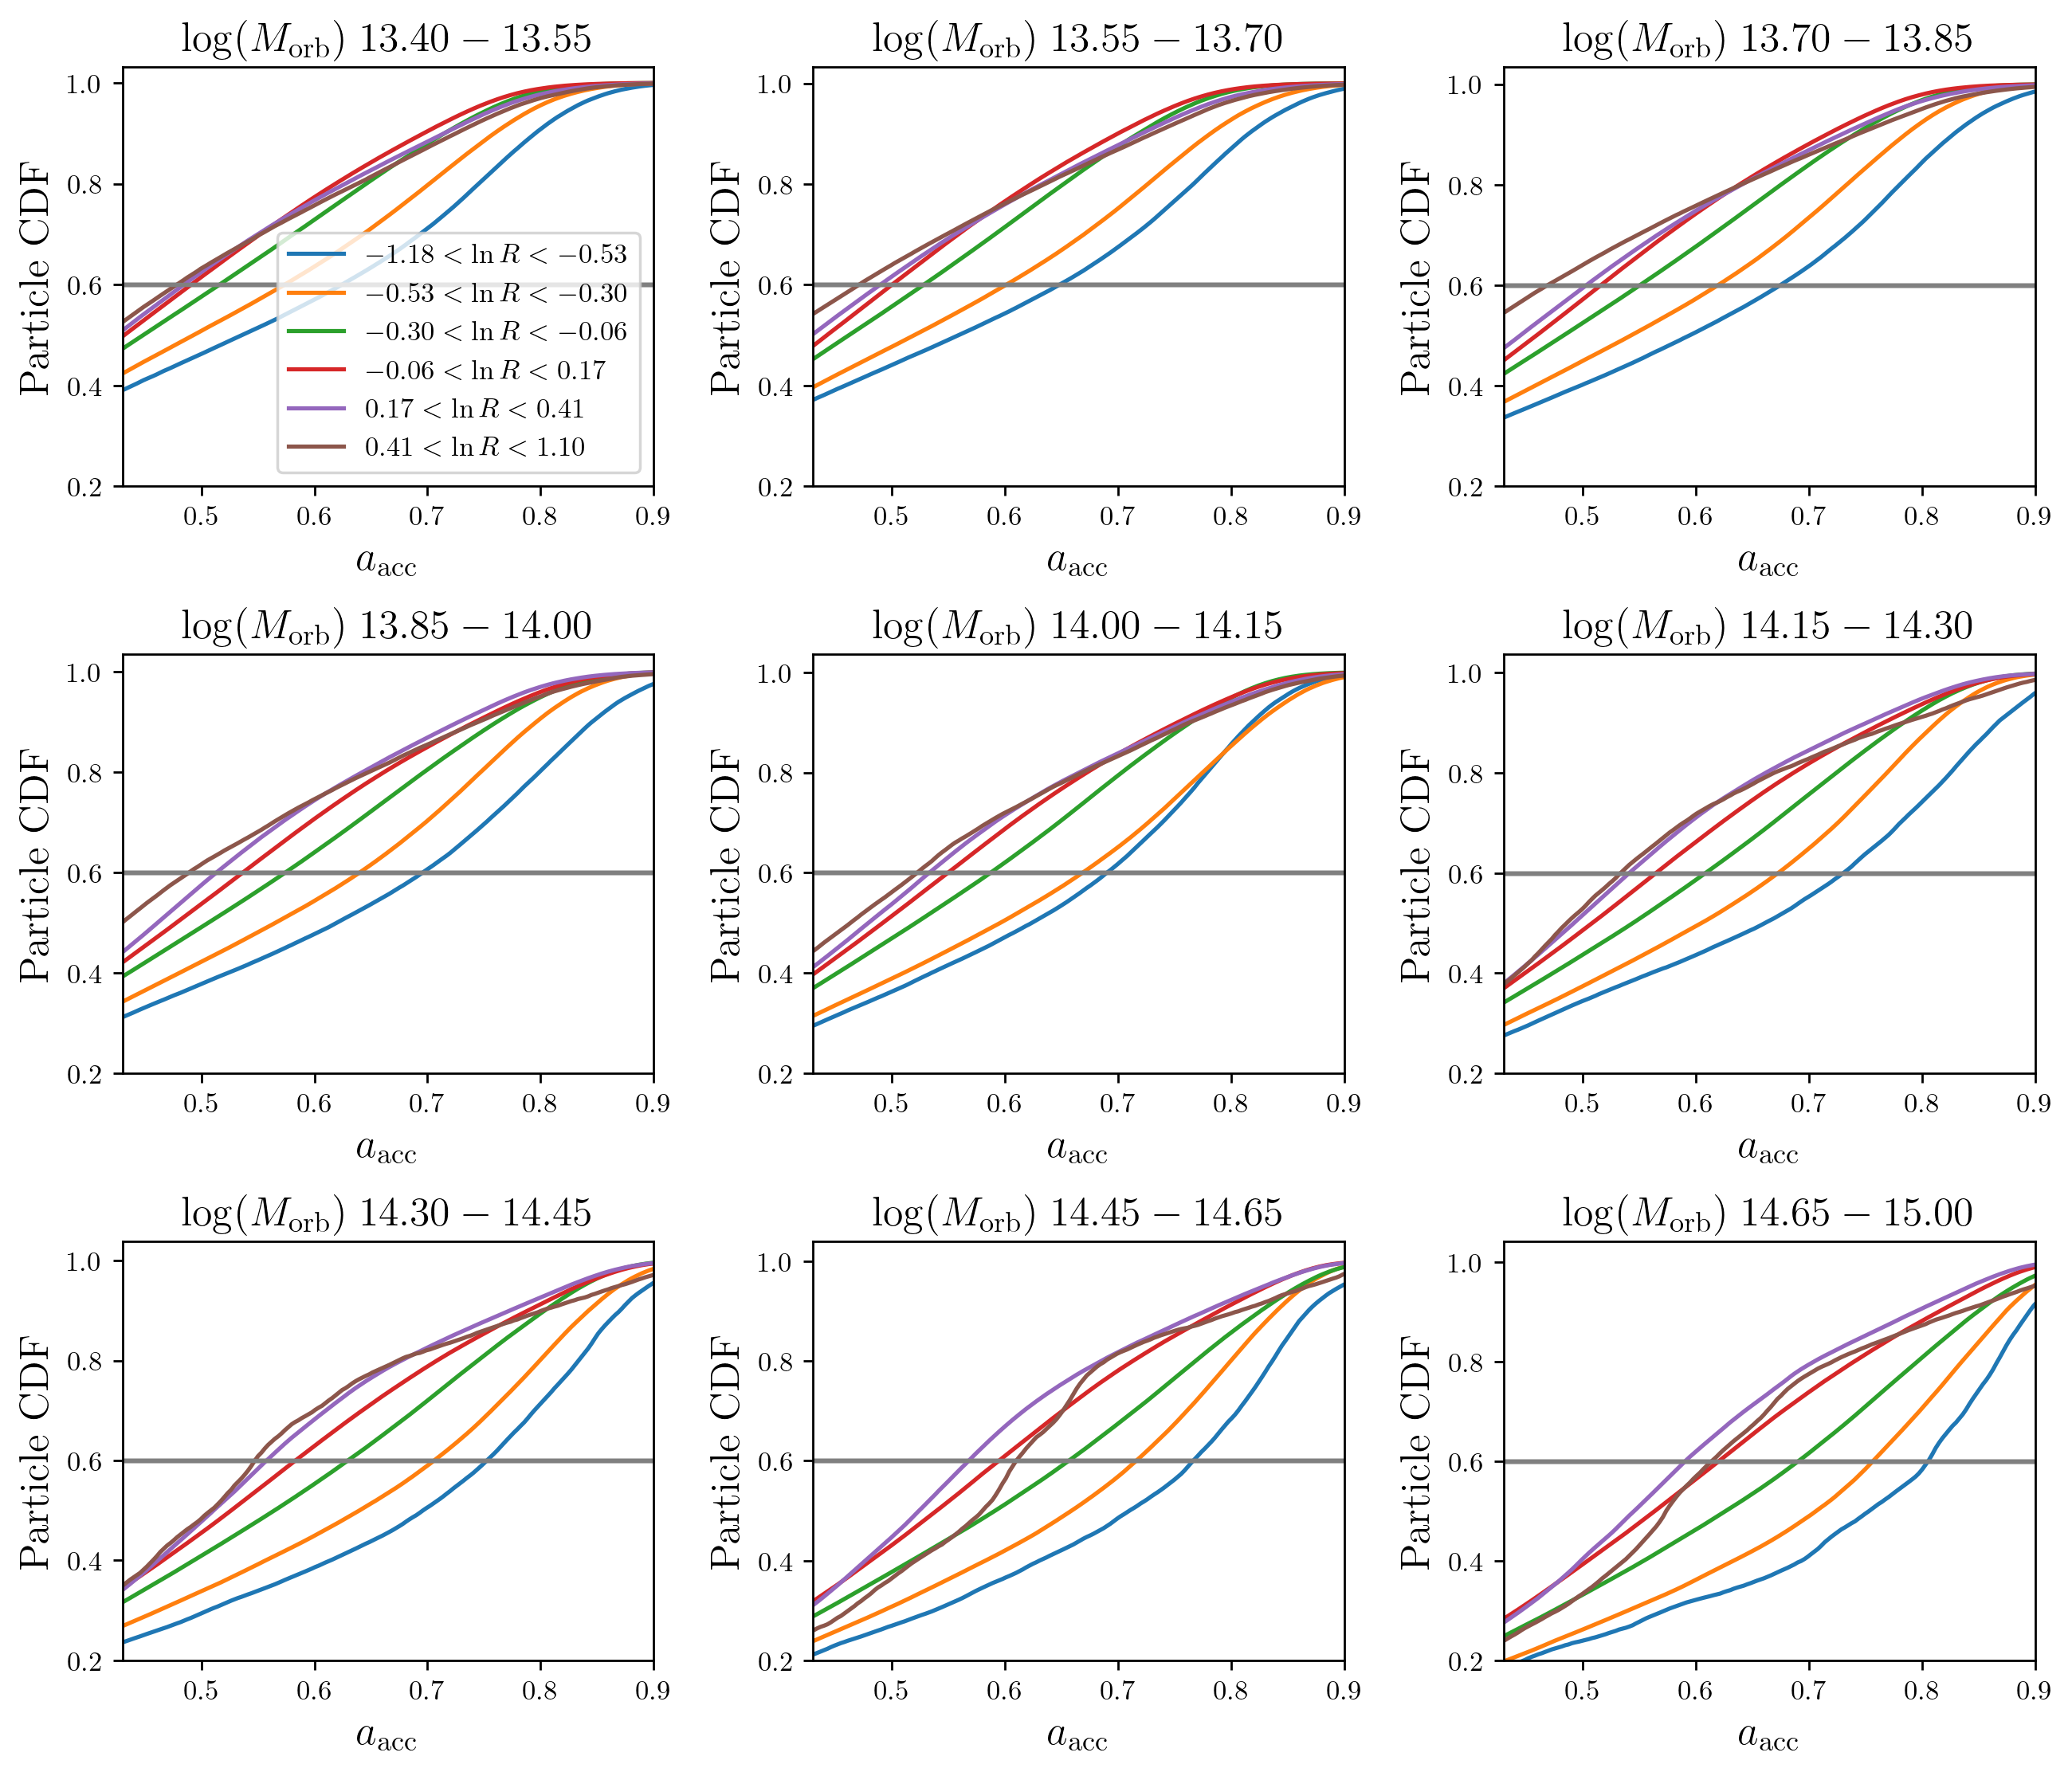

In [16]:
latex()

fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)

i = 0
for row in range(3):
    for col in range(3):
        for j in range(6):
            da = np.diff(a_acc_bins)[0]
            P = P_a_acc[MASS_BIN_STRS[i] + '/' + key_list[j]][:]
            P_unity = P / P.sum()

            if i == 0:
                axes[row, col].plot(a_acc_bins[1:], P_unity.cumsum(), label=f'${LNR_BIN_EDGES[j]:.2f} < \\ln R < {LNR_BIN_EDGES[j+1]:.2f}$')
            else:
                axes[row, col].plot(a_acc_bins[1:], P_unity.cumsum())

            axes[row, col].set_title(f'$\\log(M_{{\\rm orb}}) \\; {MASS_BIN_STRS[i]}$', fontsize=15, )
            axes[row, col].set_ylabel('Particle CDF', fontsize=15)
            axes[row, col].set_xlabel('$a_{\\rm acc}$', fontsize=15)

            axes[row, col].set_xlim(0.43, 0.9)
            axes[row, col].set_ylim(0.2)

            axes[row, col].axhline(0.6, color='gray')
        i += 1
axes[0, 0].legend()

FIGURE 4. For each massive ($M_{\rm orb} > 10^{14} M_{\odot}$) halo in our catalog, we calculate the $a_{\rm RF}$ parameter (Eq. \eqref{eq:a_RF_defn}) based on its accretion history and plot it against the halo's $R$ as a 2D histogram, with the color corresponding to the density of haloes. A linear model is fit to this data and shown as a red line.

In [17]:
# Using the a60 parameters of each halo, compute the relative formation parameter aRF for every halo more massive than 1e+14 Msun
a60 = np.load('shields_data_24/halo_a60.npy', allow_pickle=True)
a60_mask = a60 > 0.41 
Morb_mask = np.log10(Morb[a60_mask]) > 14

ind = np.digitize(np.log10(Morb), MASS_BIN_EDGES)
aRF = np.zeros(len(a60))
for i in range(1, 10):
    mask = (ind == i)
    aRF[mask] = a60[mask] / np.median(a60[mask])

In [18]:
# Fit a line using the same model as in Figure 2
result = minimize(num_cost, [-1.2, 1.88], bounds=[(-1.2, -0.5), (1.5, 2)], method='simplex', args=(aRF[a60_mask][Morb_mask], R[a60_mask][Morb_mask]))
s_a, a0 = result.x
s_a, a0

(-1.06050296107201, 1.967430451024661)

/tmp/ipykernel_1088696/649499759.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


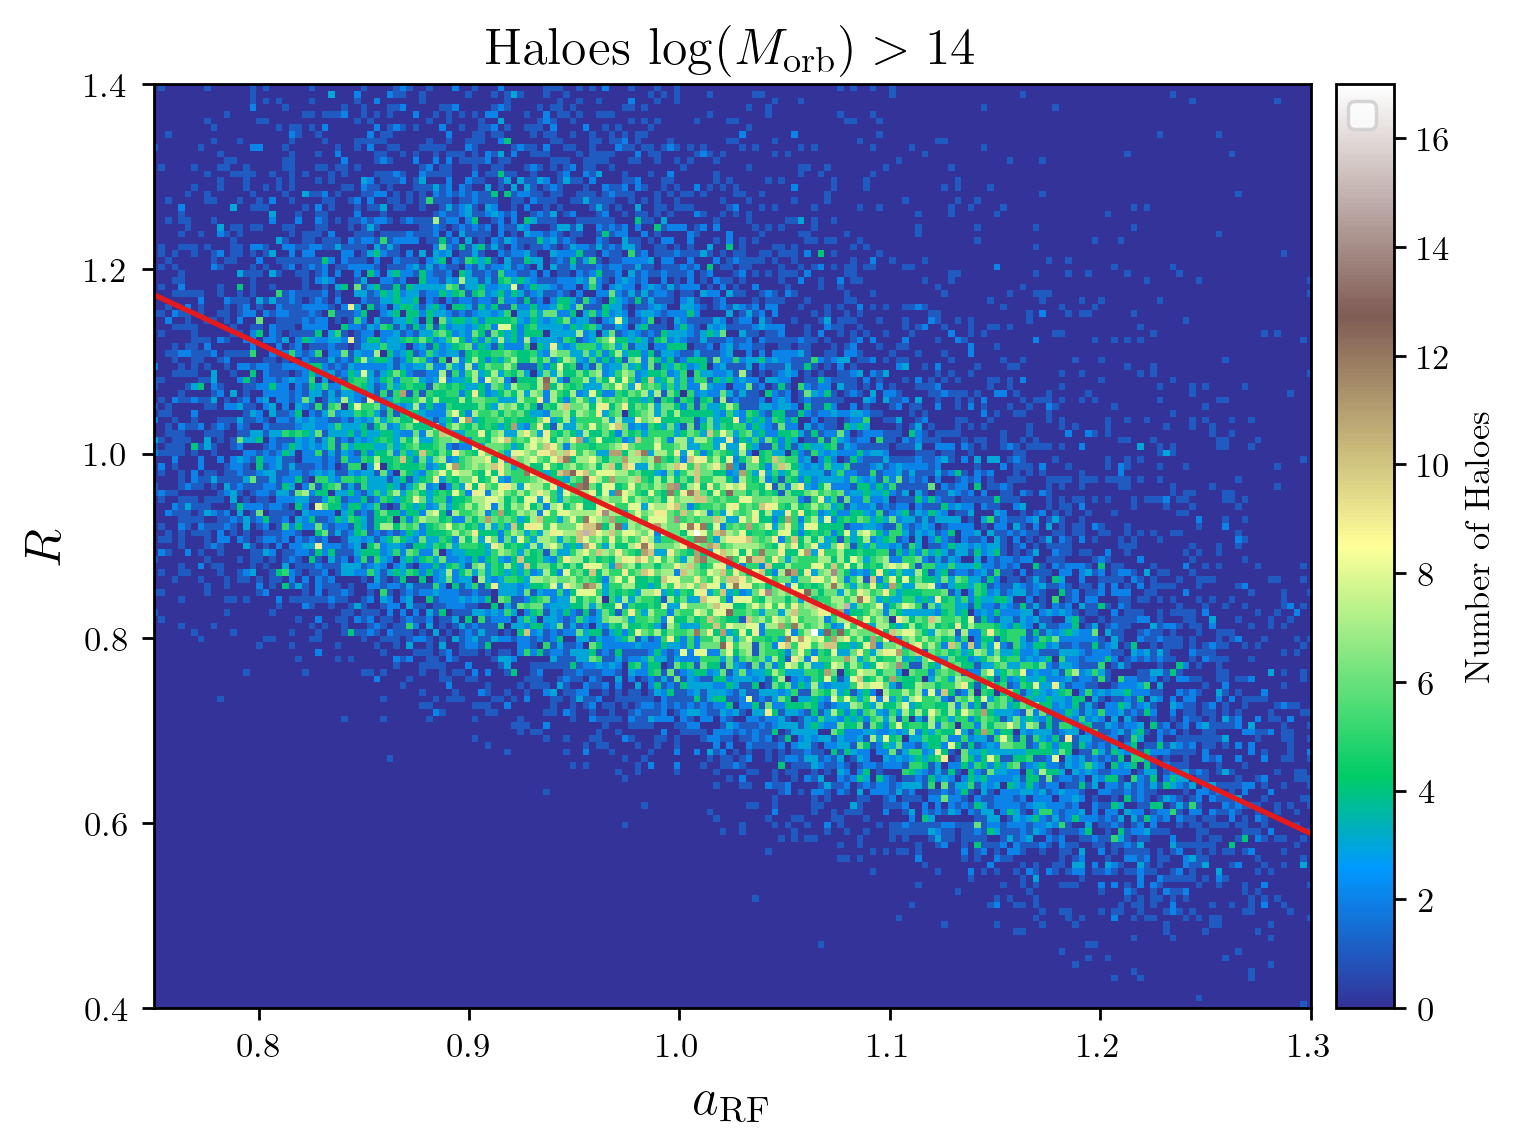

In [31]:
latex()

plt.hist2d(aRF[a60_mask][Morb_mask], R[a60_mask][Morb_mask], bins=300, cmap='terrain')
x = np.linspace(0.7, 1.3)
plt.plot(x, line(x, s_a, a0), color=COLORS[7], label='$\\a_{\\rm RF}(R)$')

plt.title('Haloes $\\log(M_{\\rm orb}) > 14$', fontsize=15)
plt.xlabel('$a_{\\rm RF}$', fontsize=15)
plt.ylabel('$R$', fontsize=15)

plt.ylim(0.4, 1.4)
plt.xlim(0.75, 1.3)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.1)

plt.legend()
plt.colorbar(label='Number of Haloes', cax=cax)

FIGURE 5. Visual representation of the relationships between $r_{\rm h}$, $\alpha_{\infty}$, $M_{\rm orb}$, and $a_{\rm RF}$. Both plots have a scatter of points representing the best-fit $r_{\rm h}$ and $\alpha_{\infty}$ from the fitting routine described in Section 3 for each halo in our catalog. \textbf{Left:} The points are color-coded by log of their mass, with the red lines representing \eqref{eq: alpha_inf_rh_relation} with given values of fixed mass. The numbers under the lines are $\log M_{\rm orb}$, corresponding to the numbers in the colorbar. \textbf{Right:} The points are color-coded by each halo's $a_{\rm RF}$, with the red lines representing \eqref{eq:R_aRF_relation}.

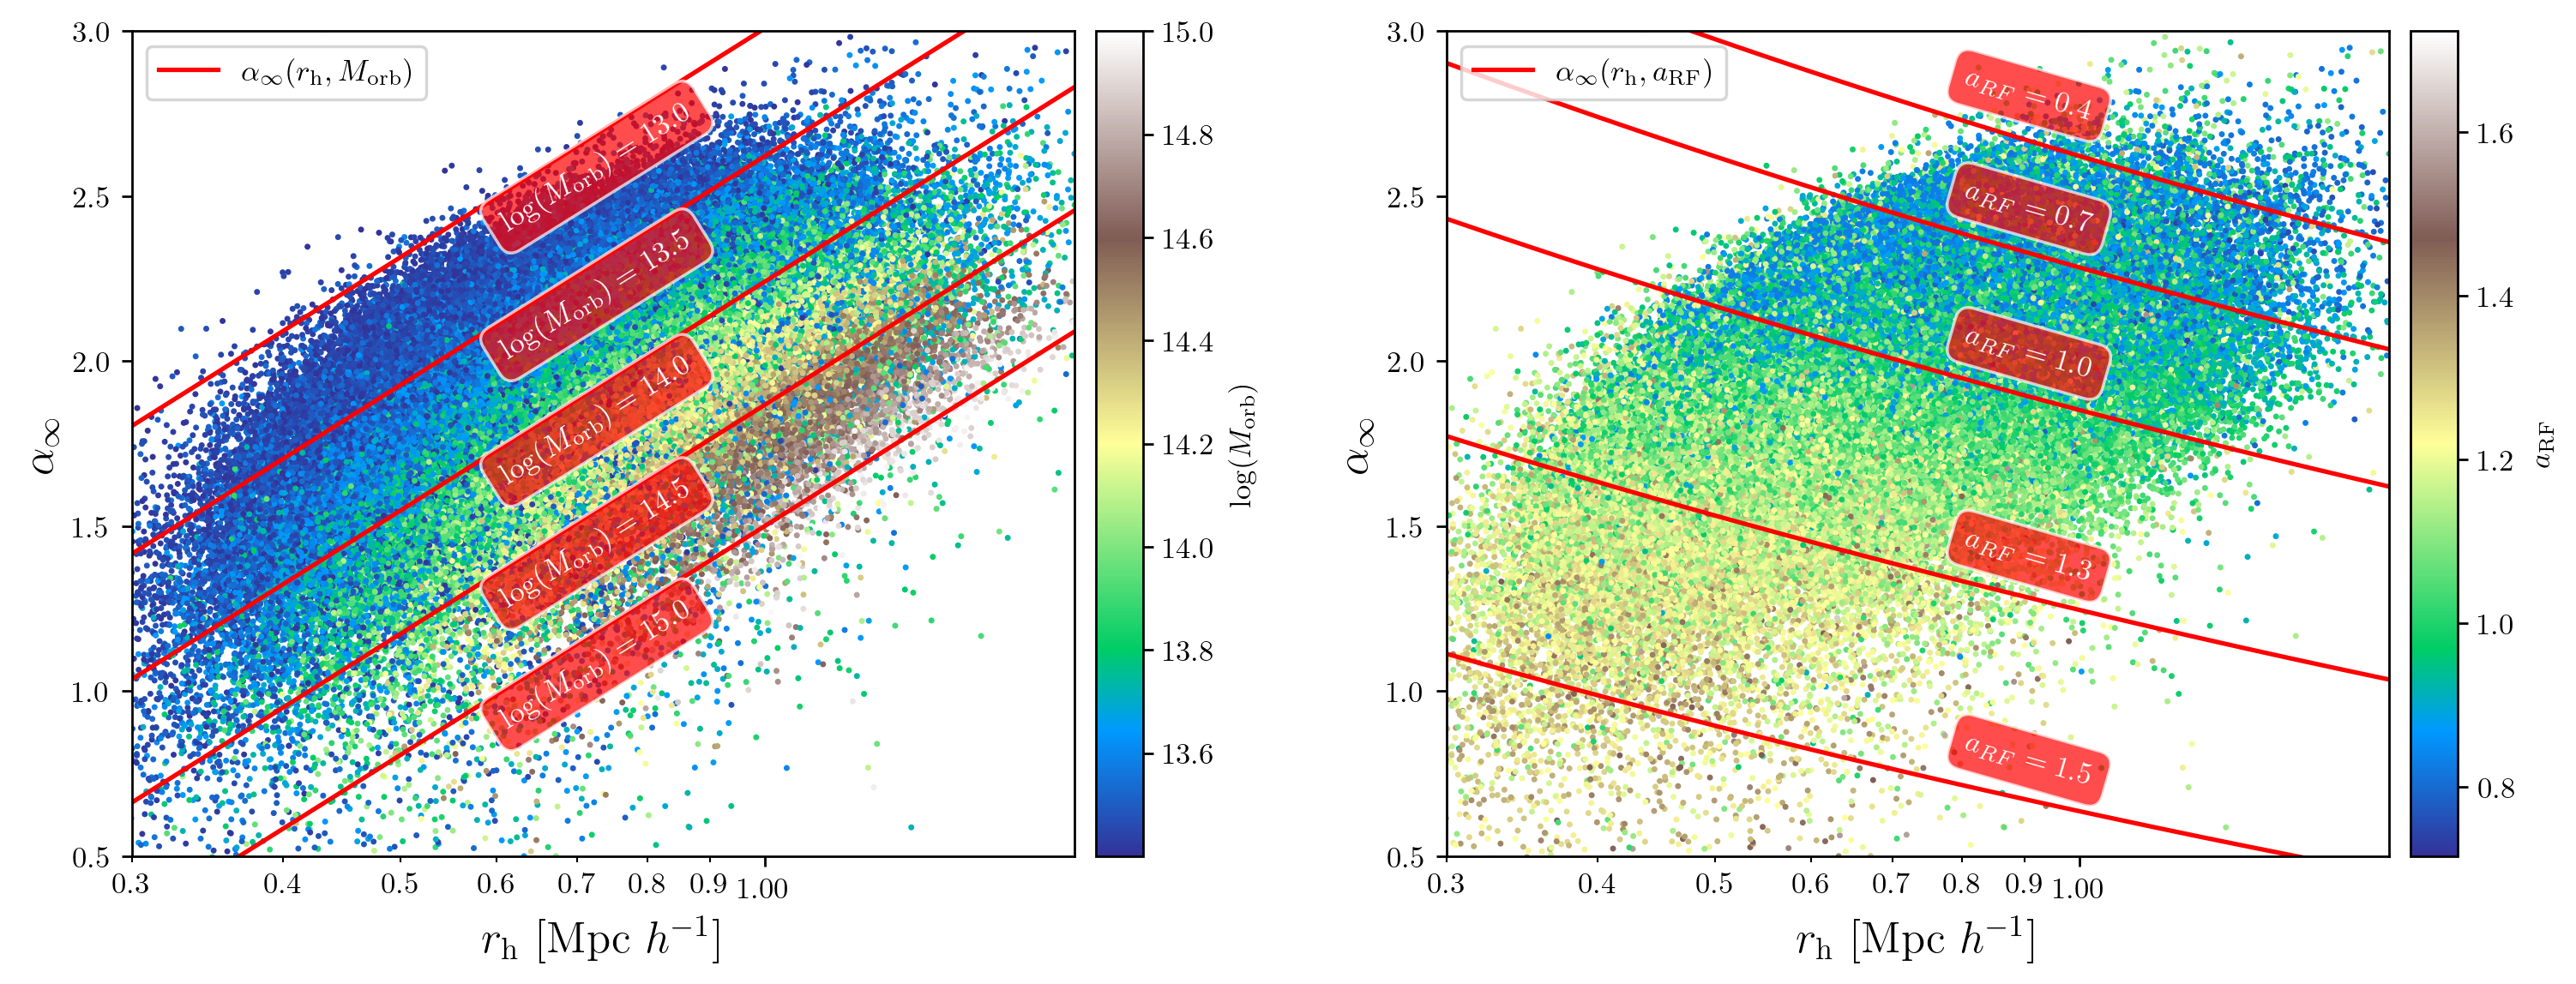

In [20]:
from matplotlib.ticker import ScalarFormatter
from matplotlib import colors, rcParams, font_manager
latex()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

sim_rh = SIMULT_PARAMS['rh'][()]
sim_alpha_inf = SIMULT_PARAMS['alpha_inf'][()]
log_Morb = np.log10(Morb)

cmap = 'terrain'
norm = colors.Normalize(vmin=np.min(log_Morb), vmax=15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.1)

# Left panel
ax[0].scatter(sim_rh, sim_alpha_inf, s=1, c=log_Morb, cmap=cmap)

ax[0].set_xlabel('$r_{\\rm h}$ [Mpc $h^{-1}$]', fontsize=15)
ax[0].set_ylabel('$\\alpha_{\\infty}$', fontsize=15)

ax[0].set_xscale('log')
ax[0].set_ylim(0.5, 3.0)
ax[0].set_xlim(0.3, 1.8)
ax[0].xaxis.set_major_formatter(ScalarFormatter())
ax[0].xaxis.set_minor_formatter(ScalarFormatter())

Morb_arr = np.array([13.0, 13.5, 14.0, 14.5, 15.0])
rh_arr = np.logspace(np.log(0.3), np.log(2.0), num=100)
for i, M in enumerate(Morb_arr):
    ax[0].text(0.6, alpha_inf(0.6, 10**M)-0.1, f'$\\log(M_{{\\rm orb}}) = {M}$', color='white', rotation=32, 
               bbox=dict(facecolor='red', alpha=0.7, edgecolor='white', boxstyle='round,pad=0.5'))
    if i == 0:
        ax[0].plot(rh_arr, alpha_inf(rh_arr, 10**M), c='r', label='$\\alpha_{\\infty}(r_{\\rm h}, M_{\\rm orb})$')
    else:
        ax[0].plot(rh_arr, alpha_inf(rh_arr, 10**M), c='r')
    
ax[0].legend()
fig.colorbar(sm, label='$\\log(M_{\\rm orb})$', cax=cax)

# Right panel
norm = colors.Normalize(vmin=np.min(aRF), vmax=np.max(aRF))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.1)

ax[1].scatter(sim_rh, sim_alpha_inf, s=1, c=aRF, cmap=cmap)

ax[1].set_xlabel('$r_{\\rm h}$ [Mpc $h^{-1}$]', fontsize=15)
ax[1].set_ylabel('$\\alpha_{\\infty}$', fontsize=15)

ax[1].set_xscale('log')
ax[1].set_ylim(0.5, 3.0)
ax[1].set_xlim(0.3, 1.8)
ax[1].xaxis.set_major_formatter(ScalarFormatter())
ax[1].xaxis.set_minor_formatter(ScalarFormatter())

aRF_arr = np.array([0.4, 0.7, 1.0, 1.3, 1.5])
for i, a in enumerate(aRF_arr):
    ax[1].text(0.8, alpha_inf_aRF(0.8, a), f'$a_{{RF}} = {a}$', color='white', rotation=-16, 
               bbox=dict(facecolor='red', alpha=0.7, edgecolor='white', boxstyle='round,pad=0.5'))
    if i == 0:
        ax[1].plot(rh_arr, alpha_inf_aRF(rh_arr, a), c='r', label='$\\alpha_{\\infty}(r_{\\rm h}, a_{\\rm RF})$')
    else:
        ax[1].plot(rh_arr, alpha_inf_aRF(rh_arr, a), c='r')

ax[1].legend()
fig.colorbar(sm, label='$a_{\\rm RF}$', cax=cax)

FIGURE 6. For each massive ($M_{\rm orb} > 10^{14} M_{\odot}$) halo in our catalog, we show: \textbf{Left:} A 2D histogram showing the best-fit halo radius obtained via the fitting procedure described in Section 3, plotted against the "predicted" value of $r_{\rm h}$ given that halo's mass ($M_{\rm orb}$) and relative halo formation time ($a_{\rm RF}$). A red line is drawn where the fit is equal to the predicted value from Eq. \eqref{eq:R_aRF_relation}. \textbf{Right:} Histograms of the ratio of the best-fit $r_{\rm h}$ to the prediction of $r_{\rm h}$ given just the halo mass (Eq. \eqref{eq:rh_power_law}) in orange, and to the prediction given both the halo mass and relative formation parameter (Eq. \eqref{eq:R_aRF_relation}) in blue. A green vertical line is drawn at 1.00, to signify where the best fit is equal to the predicted value

(0.0, 2.0)

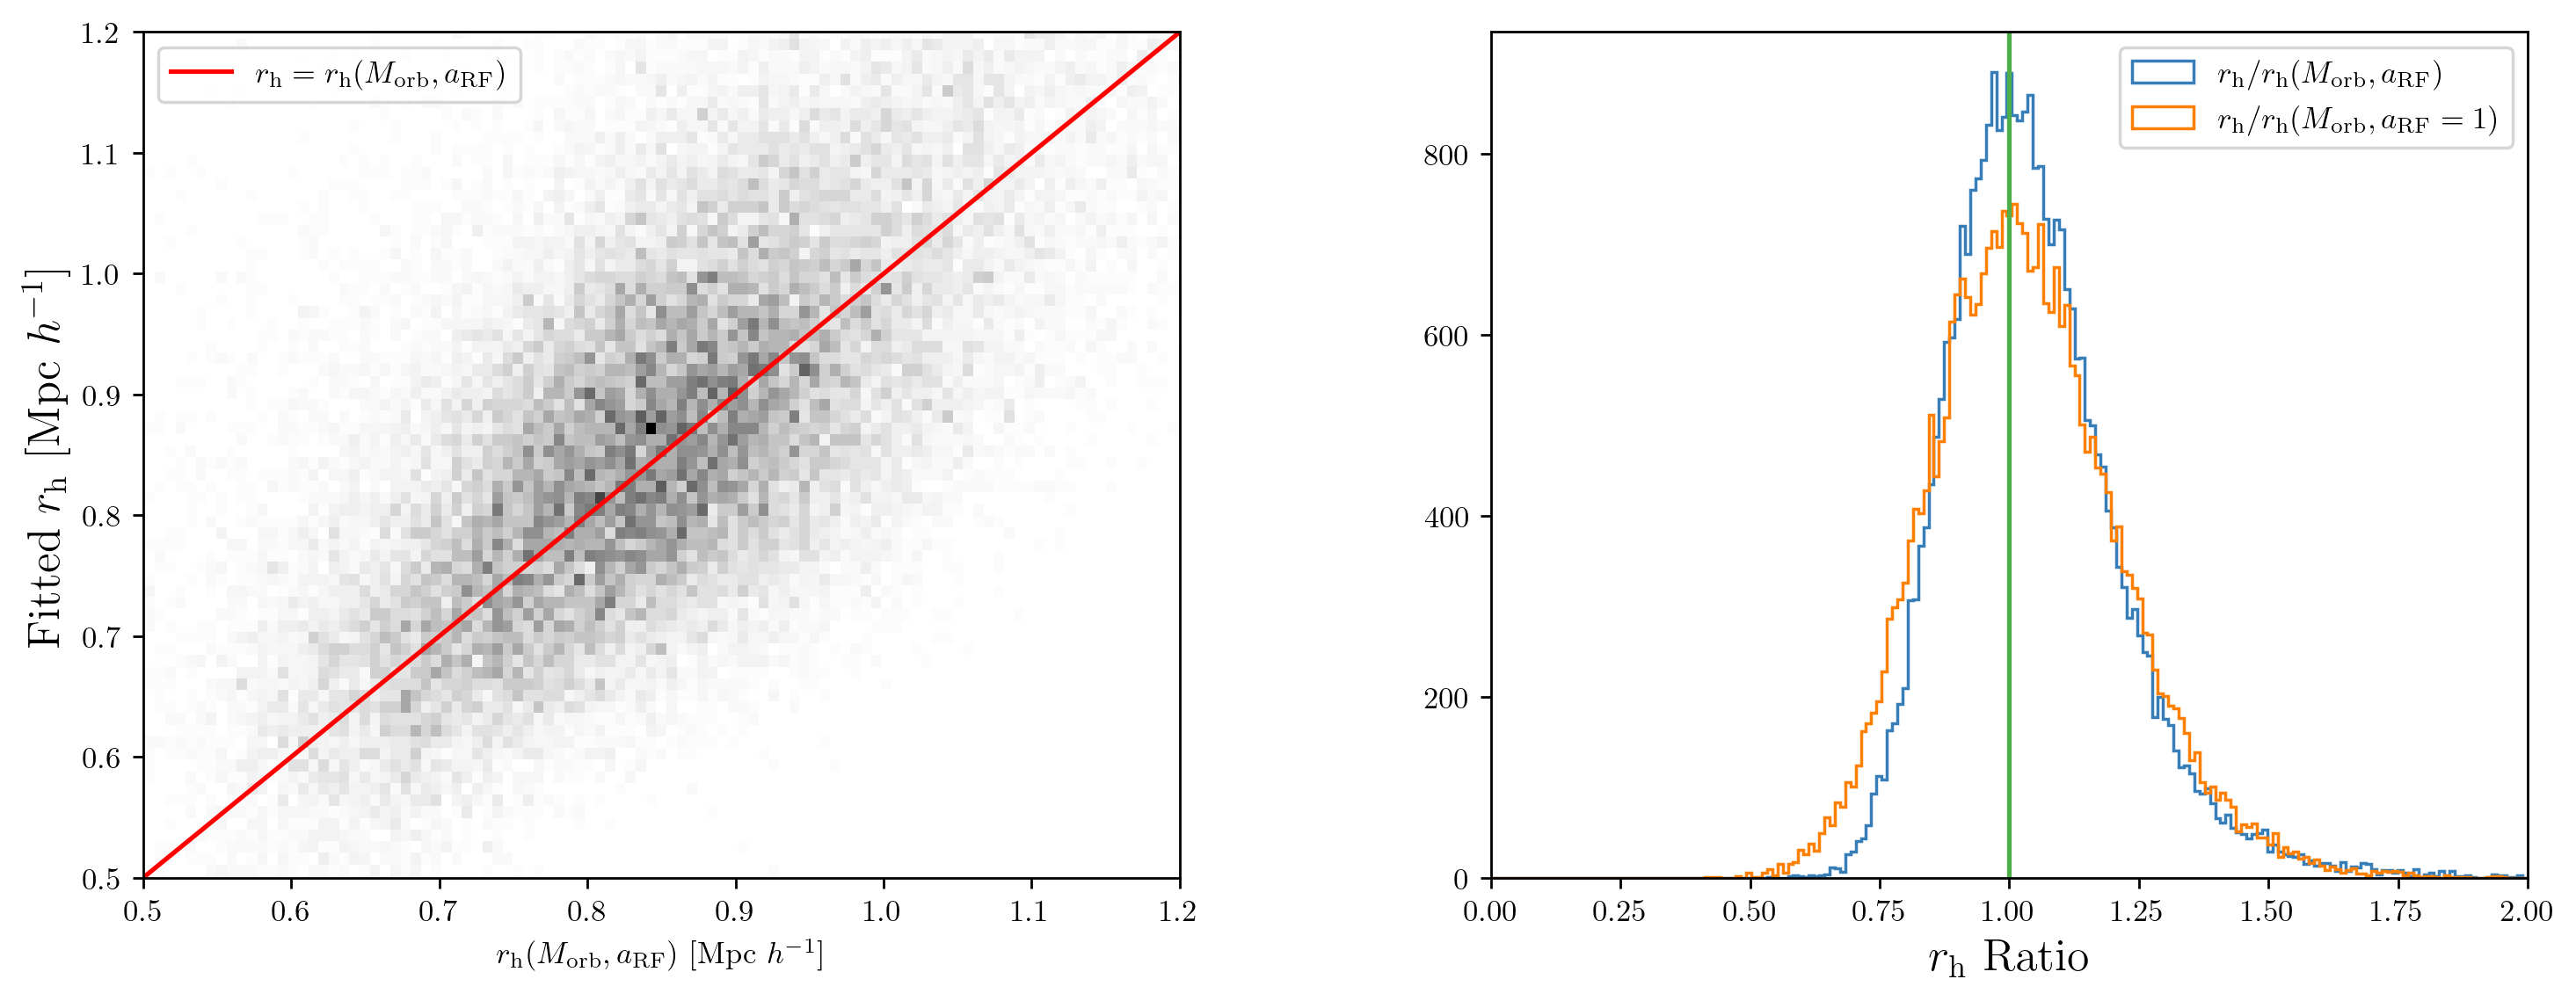

In [32]:
latex()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

rh_fit = CALIB_PARAMS['rh'][a60_mask][Morb_mask]
rh_predict = rh(Morb[a60_mask][Morb_mask], aRF[a60_mask][Morb_mask])

# Left panel
x = np.linspace(0.5, 1.2)
ax[0].hist2d(rh_predict, rh_fit, bins=200, cmap='Grays')
ax[0].plot(x, x, c='r', label='$r_{\\rm h} = r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF})$')

ax[0].set_ylabel('Fitted $r_{\\rm h}$ [Mpc $h^{-1}$]', fontsize=15)
ax[0].set_xlabel('$r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF})$ [Mpc $h^{-1}$]')

ax[0].set_xlim(0.5, 1.2)
ax[0].set_ylim(0.5, 1.2)

ax[0].legend()

# Right panel
ax[1].hist(rh_fit / rh_predict, histtype='step', bins=np.linspace(0, 2, num=200), color=COLORS[0], label='$r_{\\rm h} / r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF})$')
ax[1].hist(rh_fit / rh(Morb, aRF=1)[a60_mask][Morb_mask], histtype='step', bins=np.linspace(0, 2, num=200), color=COLORS[1], label='$r_{\\rm h} / r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF}=1)$')
ax[1].axvline(1, color=COLORS[2])

ax[1].set_xlabel('$r_{\\rm h}$ Ratio', fontsize=15)
ax[1].legend()
ax[1].set_xlim(0, 2)

FIGURE 7. We measure the variance of the distribution of the ratios of $r_{\rm h} / r_{\rm h}(M_{\rm orb}, a_{\rm RF})$ (blue, left) and $r_{\rm h} / r_{\rm h, st}(M_{\rm orb}, a_{\rm RF} = 1)$ (orange, right) for each halo in the highest four mass bins, plotted against the median number of halo particles in that bin. Eq. \eqref{eq:scatter_relation} is fit to both sets of data points in order to measure the intrinsic scatter $\sigma_0$ and the scatter due to particles $\sigma_i$, which are both printed at the top of each curve with jackknife errorbars (jackknifing procedure same as described in Section 4).

In [22]:
ratio1 = rh_fit / rh_predict 
ratio2 = rh_fit / rh(Morb, aRF=1)[a60_mask][Morb_mask]
ind = np.digitize(np.log10(Morb[a60_mask][Morb_mask]), MASS_BIN_EDGES[4:])

var1 = np.zeros(4)
var2 = np.zeros(4)

for i in range(1, 5):
    mask = (ind == i)
    var1[i-1] = np.var(ratio1[mask])
    var2[i-1] = np.var(ratio2[mask])

bin_Np = (10 ** MASS) / PARTICLE_MASS # Bin median number of particles

In [23]:
# Fit rh_scatter() (Eq. 13) to both ratios (std1 and std2)
popt1, __ = curve_fit(rh_scatter, bin_Np[5:], var1, p0=[2.37, 0.01])
popt2, __ = curve_fit(rh_scatter, bin_Np[5:], var2, p0=[2.37, 0.03])

/home/tdshield/banerjee2020_sim/functions.py:199: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var_0 + (var_i / Np))


In [24]:
popt2

array([1.34717979e+00, 7.02704894e-04])

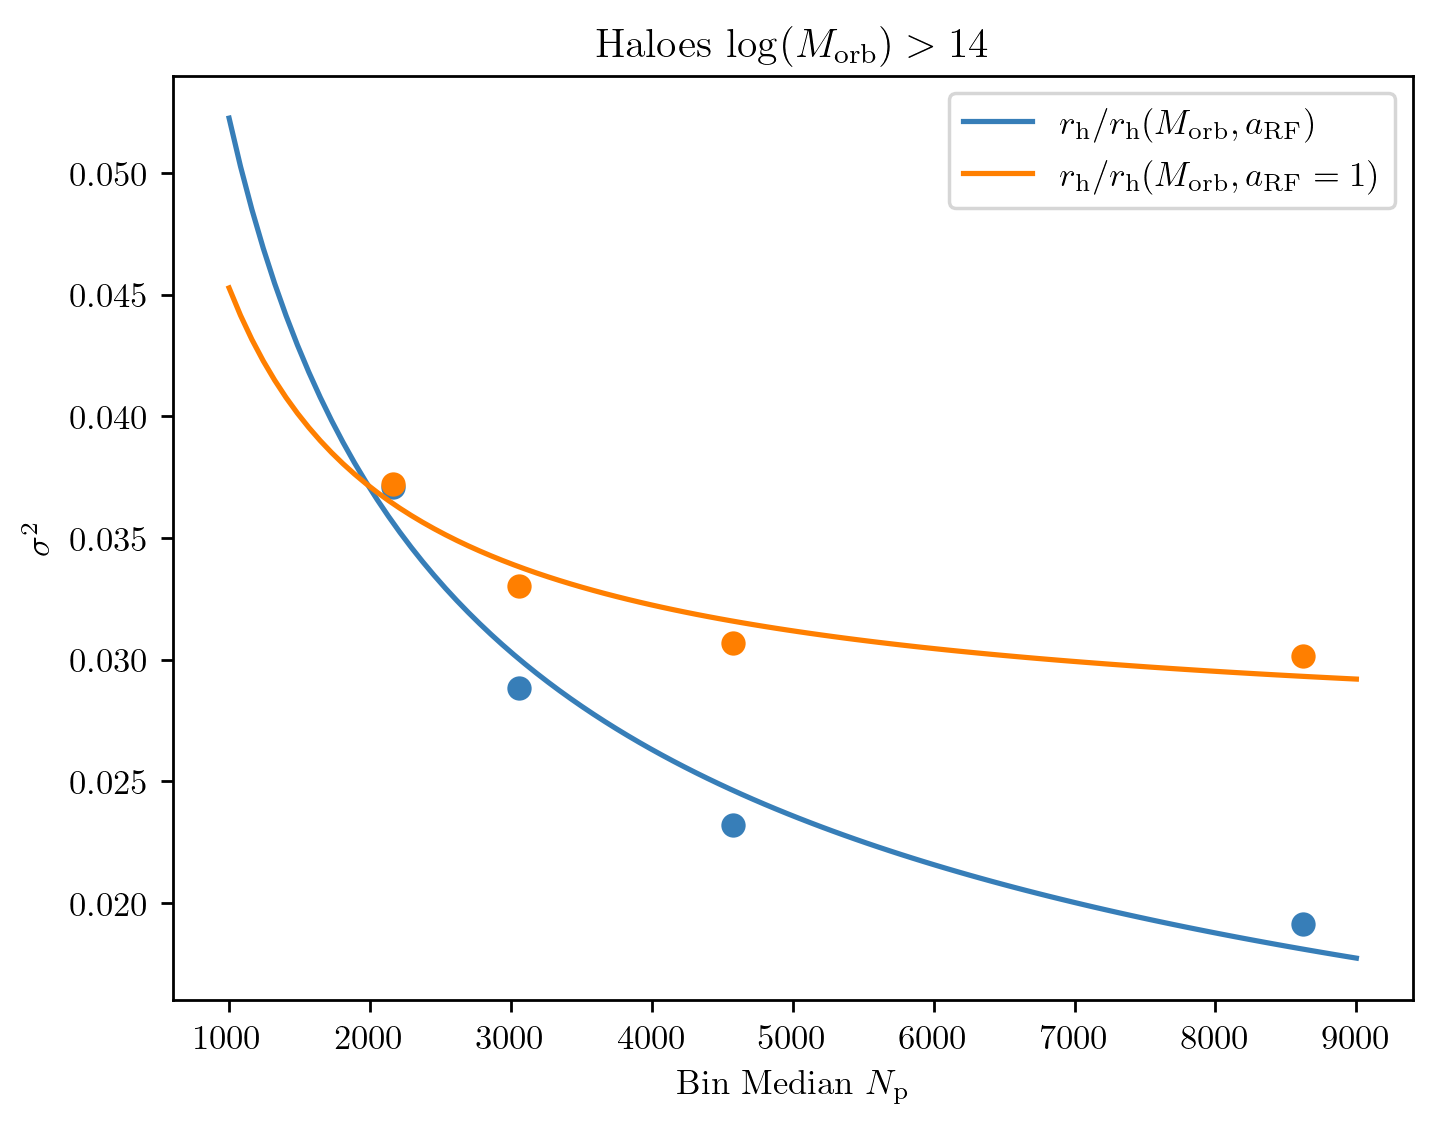

In [25]:
plt.scatter(bin_Np[5:], var1, color=COLORS[0])
plt.scatter(bin_Np[5:], var2, color=COLORS[1])

x = np.linspace(1000, 9000, num=100)
plt.plot(x, rh_scatter(x, popt1[0], popt1[1]), color=COLORS[0], label='$r_{\\rm h} / r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF})$')
plt.plot(x, rh_scatter(x, popt2[0], popt2[1]), color=COLORS[1], label='$r_{\\rm h} / r_{\\rm h}(M_{\\rm orb}, a_{\\rm RF}=1)$')

plt.title('Haloes $\\log(M_{\\rm orb}) > 14$')
plt.ylabel('$\\sigma^2$')
plt.xlabel('Bin Median $N_{\\rm p}$')

plt.legend()

TABLE 2. Fitted values of the slopes and y-intercepts from Figures 2 and 4, as well as the intrinsic scatters and slopes from Figure 7.

In [26]:
# Calculate jackknife errors for the parameters in every fit done for these figures, by splitting haloes into 8 octants, taking away one octant, and performing the fits without 
# that octant 8 times

# Mask haloes into octants 
halo_x = HALO_CATALOG['x'][HALO_MASS_MASK][:192042]
halo_y = HALO_CATALOG['y'][HALO_MASS_MASK][:192042]
halo_z = HALO_CATALOG['z'][HALO_MASS_MASK][:192042]

jk_masks = np.array([(halo_x > 0) & (halo_y > 0) & (halo_z > 0), 
                    (halo_x < 0) & (halo_y > 0) & (halo_z > 0), 
                    (halo_x > 0) & (halo_y < 0) & (halo_z > 0), 
                    (halo_x > 0) & (halo_y > 0) & (halo_z < 0), 
                    (halo_x < 0) & (halo_y < 0) & (halo_z > 0), 
                    (halo_x < 0) & (halo_y > 0) & (halo_z < 0), 
                    (halo_x > 0) & (halo_y < 0) & (halo_z < 0), 
                    (halo_x < 0) & (halo_y < 0) & (halo_z < 0)])

In [27]:
s_alpha_jks = np.zeros(8)
alpha0_jks = np.zeros(8)
s_aRF_jks = np.zeros(8)
a0_jks = np.zeros(8)

for i in range(8):
    result = minimize(num_cost, [1, 0], bounds=[(0.5, 1.5), (-0.5, 0.5)], method='simplex', args=(lnR[~jk_masks[i]], delta_alph[~jk_masks[i]])) # Fit from Figure 2
    s_alpha_jks[i], alpha0_jks[i] = result.x

    result = minimize(num_cost, [-1.2, 1.88], bounds=[(-1.2, -0.5), (1.5, 2)], method='simplex', args=(aRF[a60_mask][Morb_mask][~jk_masks[i][a60_mask][Morb_mask]], 
                                                                                                        R[a60_mask][Morb_mask][~jk_masks[i][a60_mask][Morb_mask]])) # Fit from Figure 4
    s_aRF_jks[i], a0_jks[i] = result.x

In [28]:
print(f'Error in s_alpha is {jk_error(s_alpha_jks)}')
print(f'Error in alpha0 is {jk_error(alpha0_jks)}')
print(f'Error in s_aRF is {jk_error(s_aRF_jks)}')
print(f'Error in a0 is {jk_error(a0_jks)}')

Error in s_alpha is 0.0014415150125891008
Error in alpha0 is 0.043170155248797706
Error in s_aRF is 0.12205932493665816
Error in a0 is 0.07650164464657844
